In [58]:
%matplotlib widget

from tqdm import trange
from matplotlib import cm
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from datetime import datetime, timezone, timedelta
import scipy.io
from matplotlib.colors import  Normalize
import math

import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [59]:
device
print

<function print>

In [60]:
A = 1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                # initial displacment[mm]
SIGMA = 1 # std of initial push [mm]
MU =1.5  # shear modulus [kPa]
ETA = 0.5 # viscosity [Pa.ms] 


INITIAL_GUESS_MU = 8.0
INITIAL_GUESS_ETA = 3.0

CS = math.sqrt(MU)  # shear wave speed [mm/ms]
RHO = 0.001 # density [kg/mm^3]
 
RATIO = ETA
N_NEUROS = 32 # number of neurons in the hidden layer
N_LAYERS = 4 # number of hidden layers
LR = 2e-3  # learning rate


x_range = [-20., 20.]    #[mm]
t_range = [0., 20.]      #[ms]


lambda1 = 0.2  # weight of the data loss
lambda2 = 0.8     # weight of the PDE loss
lambda3 = 0     # weight of the initial condition loss
lambda4 = 0    # weight of the initial condition loss

noise_flag = True
SNR = 7

epochs = 40000

In [61]:
# Get the current time
current_time = datetime.now(timezone(timedelta(hours=2))).strftime("%Y-%m-%d_%H-%M")

# Create the folder name with variables
folder_name = os.path.join(
    os.getcwd(),
    f"map_{current_time}_MU_{MU}_ETA_{ETA}_INITIAL_GUESS_MU_{INITIAL_GUESS_MU}_INITIAL_GUESS_ETA_{INITIAL_GUESS_ETA}",
)

try:
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully!")
except FileExistsError:
    print(f"Folder '{folder_name}' already exists.")
except Exception as e:
    print(f"Error occurred while creating the folder: {e}")

Folder 'c:\Users\Wayne\Desktop\CUDI-contrast-ultrasound dispersion imaging\28_weekly_update_25052024\map_2024-06-23_16-17_MU_1.5_ETA_0.5_INITIAL_GUESS_MU_8.0_INITIAL_GUESS_ETA_3.0' created successfully!


In [62]:
sample_seed = 1024
initialization_seed = 1024

In [63]:
torch.manual_seed(sample_seed)
np.random.seed(sample_seed)

In [64]:
def get_displacement_wave_equation_output(u_init: np.array, u_init_2: np.array, DX: float, DT: float, NT: int, rho: float, mu: float, eta:float,  n_padding: int, x_values:np.array):
    NX = len(u_init) + 2 * n_padding # Add padding to deal with boundary conditions
    padding = np.zeros(n_padding)

    a = (mu * DT**2) / (rho * DX**2) #linear constant
    b = (eta * DT) / (rho * DX**2) #viscous constant


    u = np.zeros((NX, NT))
    u[:, 0] = np.hstack((padding, u_init, padding)) #add padding to deal with boundary conditions

    #As the simulation can take quite a long time to calculate and might need to be done at very small increments, it can be useful to continue a previous simulation, using the last two results from the previous simulation.
    if u_init_2 is None:
        for x in range(1, NX-1):
            u_linear = a * (u[x+1, 0] - 2 * u[x, 0] + u[x-1, 0])
            u_viscous = 0
            u[x, 1] = u_linear + u_viscous + u[x, 0]
    else:
        u[:, 1] = np.hstack((padding, u_init_2, padding))

    for t in range(1, NT-1):
        for x in range(1, NX-1):
            u_linear = a * (u[x+1, t] - 2 * u[x, t] + u[x-1, t])
            u_viscous = b *  (u[x+1, t] - 2 * u[x, t] + u[x-1, t] - u[x+1, t-1] + 2 * u[x, t-1] - u[x-1, t-1])
            u[x, t+1] = u_linear + u_viscous  + 2 * u[x, t] - u[x, t-1]

    plt.xlabel('x')
    plt.ylabel('u')

    for t in range(0, NT, 100):
        plt.plot(x_values, u[:, t])

    return u

# Function to generate a Gaussian impulse

def gaussian(x):
    return f_amp * np.exp(-x**2 / sigma**2)

# Tissue parameters
eta = ETA
mu = MU * 1e3      # Convert from mm/ms to m/s
rho = RHO * 1e6
n_padding = 0


# # # # Simulation parameters for MU=12.8   ETA=4.9
# DX = 1e-3
# DT = 1e-5
# NT = 2000

# # Spatial values
# x_values = np.arange(-0.08, 0.08, DX)


# # Simulation parameters for MU=1.5 4.0 7.0   ETA=0.5 1.2 2.0
DX = 1e-3
DT = 1e-4
NT = 200


# DX = 1e-4
# DT = 1e-6
# NT = 20000

# Spatial values
x_values = np.arange(-0.05, 0.05, DX)

# Parameters for Gaussian impulse
f_amp = 0.001
sigma = 0.001
u_init = np.zeros(len(x_values), dtype=np.float64)

for x in range(len(u_init)):
    u_init[x] = gaussian(x_values[x])

u_fdm = get_displacement_wave_equation_output(u_init=u_init, u_init_2=None, DX=DX, DT=DT, NT=NT, rho=rho, mu=mu, eta=eta, n_padding=n_padding, x_values=x_values)

In [65]:
def awgn(signal, snr_dB):
    """
    Add Gaussian noise to a signal.

    Parameters:
    signal: The input signal, could be a single value, list, or NumPy array.
    snr_dB: The signal-to-noise ratio in decibels.

    Returns:
    A signal with noise added, having the same shape as the input.
    """
    # Calculate the power of the signal
    signal_power = np.mean(np.abs(signal) ** 2)

    # Calculate the power of the noise based on SNR
    noise_power = signal_power / (10 ** (snr_dB / 10))

    # Generate Gaussian noise
    noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)

    # Add noise to the signal
    noisy_signal = signal + noise

    return noisy_signal

In [66]:
# Add noise to the signal with a SNR of 7 dB

u_fdm_noisy = awgn(u_fdm, SNR)


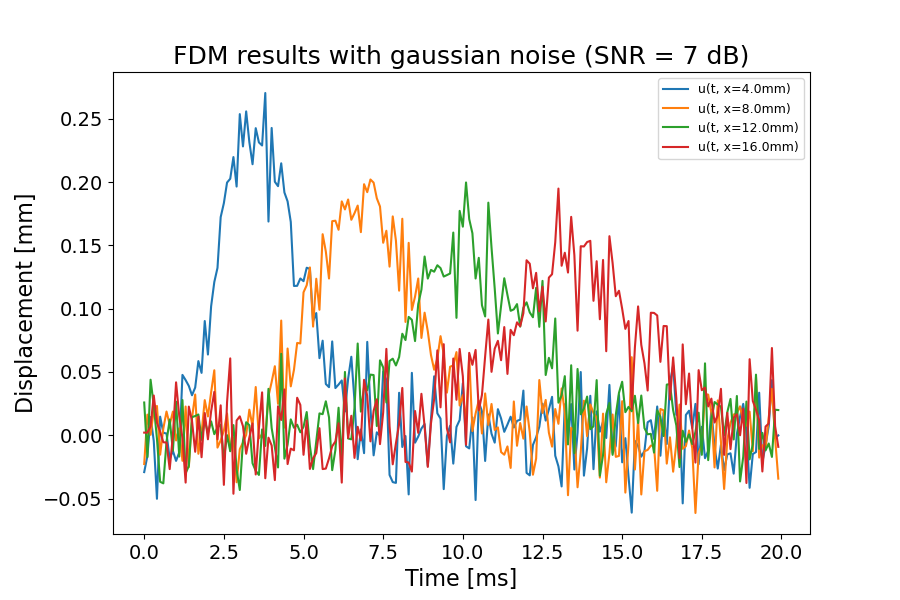

In [68]:
# Create a single figure
fig, ax = plt.subplots(figsize=(9, 6))

time_values = np.arange(
    0, u_fdm.shape[1] * DT * 1000, DT * 1000
)  # Convert seconds to milliseconds

# Find the indices corresponding to the desired positions
x_positions = [0.004, 0.008, 0.012, 0.016]
x_indices = [int((x - x_values[0]) / DX) for x in x_positions]

# Select the corresponding u values for each position
u_at_positions = [u_fdm_noisy[x_index, :] for x_index in x_indices]

# Plot the selected u values against time values for each position
for i, u_at_position in enumerate(u_at_positions):
    plt.plot(
        time_values, u_at_position * 1000, label=f"u(t, x={x_positions[i]*1000}mm)"   
    )  # Convert meters to millimeters

# Add legend
plt.legend(fontsize=9)

# Add labels and title
plt.xlabel("Time [ms]", fontsize=16)  
plt.ylabel("Displacement [mm]", fontsize=16)
plt.title(f"FDM results with gaussian noise (SNR = {SNR} dB)", fontsize=18)

# Increase tick label size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.ylim(-0.02, 0.25)
# Save the plot
fig.savefig(os.path.join(folder_name, "FDM results with gaussian noise.png"))

# Show the plot
plt.show()

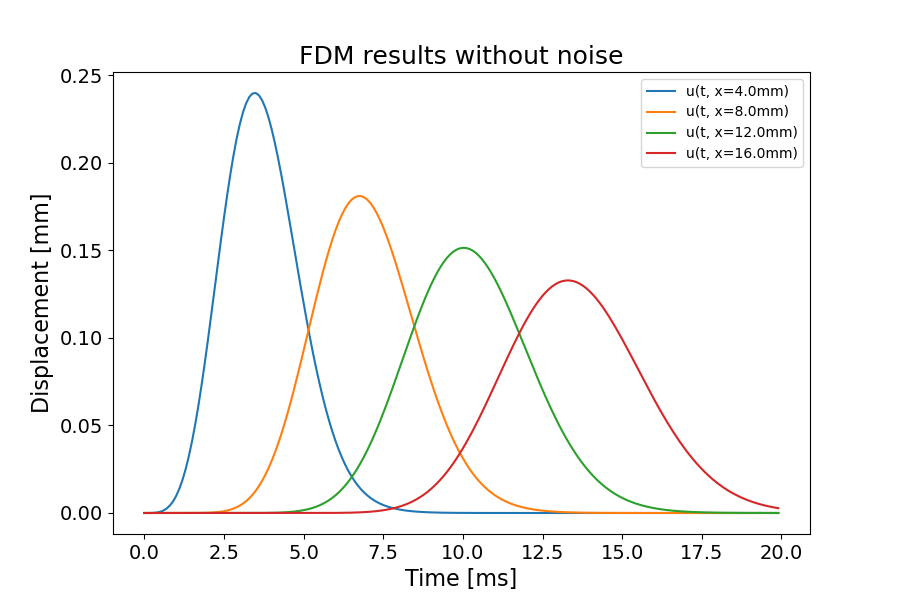

In [69]:
# Create a single figure
fig, ax = plt.subplots(figsize=(9, 6))
time_values = np.arange(
    0, u_fdm.shape[1] * DT * 1000, DT * 1000
)  # Convert seconds to milliseconds

# Find the indices corresponding to the desired positions
x_positions = [0.004, 0.008, 0.012, 0.016]
x_indices = [int((x - x_values[0]) / DX) for x in x_positions]

# Select the corresponding u values for each position
u_at_positions = [u_fdm[x_index, :] for x_index in x_indices]

# Plot the selected u values against time values for each position
for i, u_at_position in enumerate(u_at_positions):
    plt.plot(
        time_values, u_at_position * 1000, label=f"u(t, x={x_positions[i]*1000}mm)"
    )  # Convert meters to millimeters

# Add legend
plt.legend()

# Add labels and title

plt.title("FDM results without noise", fontsize=18)
plt.xlabel("Time [ms]", fontsize=16)  
plt.ylabel("Displacement [mm]", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Save the plot
fig.savefig(os.path.join(folder_name, "FDM - Prediction.png"))

# Show the plot
plt.show()

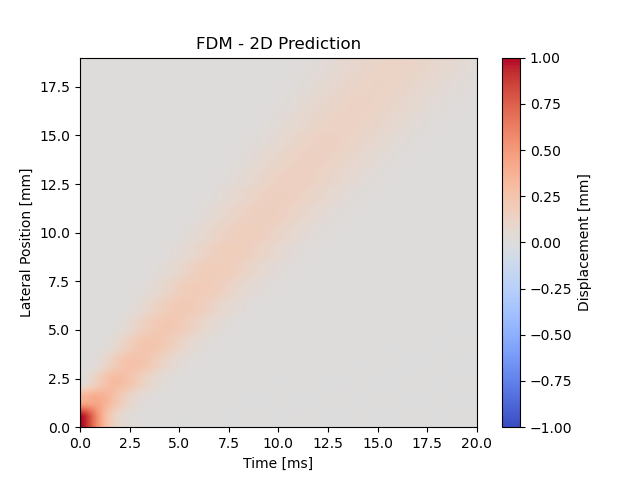

In [12]:


# Create a new figure for the heatmap
fig, ax = plt.subplots(figsize=(9, 6))

# Define spatial values in millimeters
spatial_values = np.arange(0, 0.02, DX)
spatial_values_mm = spatial_values * 1000  # Convert meters to millimeters


u_fdm_2d = u_fdm * 1000


# Define the desired spatial and temporal ranges in physical units
spatial_plot_range = 0.05
spatial_plot_start = 0  # Starting spatial position in meters
spatial_plot_end = 0.02  # Ending spatial position in meters
temporal_plot_end = 0.02  # Ending time in seconds

# Convert spatial and temporal ranges to indices
spatial_plot_start_index = int(
    (spatial_plot_start + spatial_plot_range) / DX
)  # Convert to index
spatial_plot_end_index = int((spatial_plot_end + spatial_plot_range) / DX)  # Convert to index
temporal_plot_end_index = int(temporal_plot_end / DT)  # Convert to index

# Define the temporal start index directly
temporal_plot_start_index = 0  # Start index for temporal range

# Slice the u_fdm_2d array to get the desired portion of data
u_fdm_2d_plot_sliced = u_fdm_2d[
    spatial_plot_start_index:spatial_plot_end_index, temporal_plot_start_index:temporal_plot_end_index
]
# Determine color mapping range
vmin = np.min(u_fdm_2d_plot_sliced)
vmax = np.max(u_fdm_2d_plot_sliced)

# Determine the absolute maximum value
abs_max = max(abs(vmin), abs(vmax))


# Plot the heatmap
heatmap = plt.imshow(
    u_fdm_2d_plot_sliced,
    extent=[
        0,
        0.02 * 1000,
        0,
        spatial_values_mm[-1],
    ],  # Convert seconds to milliseconds
    aspect="auto",
    cmap='coolwarm',
    vmin=-abs_max,
    vmax=abs_max,
    origin="lower",
)


# Add colorbar
plt.colorbar(label="Displacement [mm]")

# Set labels and title
plt.xlabel("Time [ms]")  # Change x-axis label to milliseconds
plt.ylabel("Lateral Position [mm]")  # Change y-axis label to millimeters
plt.title("FDM - 2D Prediction")


plt.show()
fig.savefig(os.path.join(folder_name, "FDM - 2D Prediction.png"))

In [13]:
u_fdm_2d_plot_sliced.shape

(20, 200)

In [14]:
from scipy import interpolate

# Define the range for x_values


x_min = -0.02


x_max = 0.02


# Find the indices corresponding to the range in x_values


start_index = np.argmax(x_values >= x_min)


end_index = np.argmax(x_values >= x_max)


# Extract the portion of x_values within the specified range


X = x_values[start_index:end_index]


# Extracting the time steps (T)


T = np.arange(u_fdm.shape[1]) * DT  # DT is the time step size


# Define the desired spatial and temporal ranges in physical units


spatial_range = 0.05


spatial_start = -0.02  # Starting spatial position in meters


spatial_end = 0.02  # Ending spatial position in meters


temporal_end = 0.02 # Ending time in seconds
temporal_range = 0.02


# Convert spatial and temporal ranges to indices


spatial_start_index = int((spatial_start + spatial_range) / DX)  # Convert to index


spatial_end_index = int((spatial_end + spatial_range) / DX)  # Convert to index


temporal_end_index = int((temporal_end ) / DT) + 1  # Convert to index


# Define the temporal start index directly


temporal_start_index = 0  # Start index for temporal range


# Slice the u_fdm_2d array to get the desired portion of data
u_fdm_without_noise = u_fdm[spatial_start_index:spatial_end_index, temporal_start_index:temporal_end_index]

# Slice the u_fdm_2d array to get the desired portion of data
u_fdm_noisy = u_fdm_noisy[spatial_start_index:spatial_end_index, temporal_start_index:temporal_end_index]


In [16]:
X_train = X
T_train = T[temporal_start_index:temporal_end_index]

if noise_flag:
    u_train = u_fdm_noisy
else:
    u_train = u_fdm_without_noise


In [17]:
print("Training set shapes:")
print("X_train shape:", X_train.shape)
print("T_train shape:", T_train.shape)
print("u_train shape:", u_train.shape)


Training set shapes:
X_train shape: (40,)
T_train shape: (200,)
u_train shape: (40, 200)


In [18]:
T_train[-1]

0.0199

In [19]:
print("X_train shape:", X_train.shape)
print("X_train range: [{}, {}]".format(X_train.min(), X_train.max()))
print()
print("T_train shape:", T_train.shape)
print("T_train range: [{}, {}]".format(T_train.min(), T_train.max()))
print()
print("u_train shape:", u_train.shape)

X_train shape: (40,)
X_train range: [-0.019999999999999976, 0.01900000000000006]

T_train shape: (200,)
T_train range: [0.0, 0.0199]

u_train shape: (40, 200)


In [21]:
temporal_end_index

201

In [22]:
T_train.shape

(200,)

In [24]:
# Convert spatial coordinates to millimeters
X_train *= 1000


# Convert temporal coordinates to milliseconds
T_train *= 1000

# Convert displacement values to millimeters
u_train *= 1000 

In [27]:
# find the indices of the zeros in the T_train array
zero_indices = np.where(T_train == 0)[0]

# delete the zeros from the T_train array
T_train = np.delete(T_train, zero_indices, axis=0)

# find the indices of the zeros in the u_train array
u_train = np.delete(u_train, zero_indices, axis=1)


In [28]:
print("Training set shapes:")
print("X_train shape:", X_train.shape)
print("T_train shape:", T_train.shape)
print("u_train shape:", u_train.shape)



Training set shapes:
X_train shape: (40,)
T_train shape: (199,)
u_train shape: (40, 199)


In [29]:
print (X_train[1,])
print(T_train[1,])
print(u_train[1,1])

-18.999999999999975
0.2
0.005759140373788924


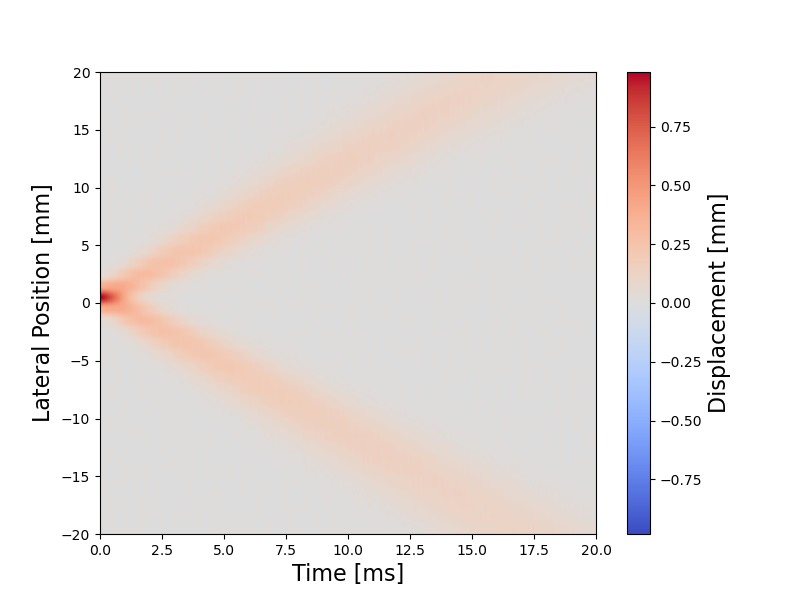

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Assuming u_train is already defined
vmin = np.min(u_train)
vmax = np.max(u_train)

# Determine the absolute maximum value
abs_max = max(abs(vmin), abs(vmax))

# Plotting the heatmap for the training set
plt.figure(figsize=(8, 6))

plt.imshow(
    u_train,
    extent=[0, 20, -20, 20],
    aspect="auto",
    cmap="coolwarm",
    vmin=-abs_max,
    vmax=abs_max,
    origin="lower",
)

# Add colorbar
cbar = plt.colorbar()
cbar.set_label("Displacement [mm]", fontsize=16) 

# Set labels and title
plt.xlabel("Time [ms]", fontsize=16)  # Change x-axis label to milliseconds
plt.ylabel("Lateral Position [mm]", fontsize=16)  # Change y-axis label to millimeters


# Save the plot to a file
plt.savefig(os.path.join(folder_name, "Training_set.png"))

# Display the plot
plt.show()

In [458]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
T_train = torch.tensor(T_train, dtype=torch.float32).to(device)
u_train = torch.tensor(u_train, dtype=torch.float32).to(device)


In [459]:
print("U Shape:", u_train.shape)
print("X" , X_train.shape)
print("T", T_train.shape)

U Shape: torch.Size([40, 199])
X torch.Size([40])
T torch.Size([199])


In [460]:
class Net(nn.Module):

    def __init__(self, n_neurons=N_NEUROS, n_layers=N_LAYERS):
        super(Net, self).__init__()

        # Set the random seed
        torch.manual_seed(initialization_seed)
        np.random.seed(initialization_seed)

        self.seq = torch.nn.Sequential()
        n_inputs = 2

        for i in range(n_layers):
            self.seq.add_module(f"lin_{i}", nn.Linear(n_inputs, n_neurons))
            # self.seq.add_module(f"batch_norm_{i}", nn.BatchNorm1d(n_neurons))
            self.seq.add_module(f"tanh_{i}", nn.Tanh())
            n_inputs = n_neurons

        self.seq.add_module(f"lin_{n_layers}", nn.Linear(n_inputs, 1))

        # Set weight initialization method for each linear layer
        for module in self.seq:
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_normal_(module.weight)

    def forward(self, x, t):
        return self.seq(torch.cat([x, t], axis=1))

In [461]:
print("U Shape:", u_train.shape)
print("X" , X_train.shape)
print("T", T_train.shape)

U Shape: torch.Size([40, 199])
X torch.Size([40])
T torch.Size([199])


# Window slice

In [462]:
# # slice the training data into 8 parts
# window_size =     len(X_train) //  8     # number of space points in each window      10 points = 5mm
# X_parts = len(X_train) // window_size

# sliced_tensors = u_train.chunk(X_parts, dim=0)

# # Print the shape of each slice
# for i, tensor_slice in enumerate(sliced_tensors):
#     print(f"Slice {i+1} shape: {tensor_slice.shape}")

# Whole map dataloader

In [463]:
from torch.utils.data import DataLoader, TensorDataset
pairs = []
pairs_u = []

for i in range (len(X_train)):
    for j in range (len(T_train)):
        pairs.append([X_train[i], T_train[j]])
        pairs_u.append(u_train[i,j])
# Convert pairs and pairs_u to tensors
pairs_tensor = torch.tensor(pairs)
pairs_u_tensor = torch.tensor(pairs_u)

# Create a TensorDataset
dataset = TensorDataset(pairs_tensor, pairs_u_tensor)

# Set the batch size
batch_size = len(X_train) * len(T_train)

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Window sliced dataloader

In [464]:
# from torch.utils.data import DataLoader, TensorDataset
# dataloader_window = []


# for i in range (X_parts):
#     pairs = []
#     pairs_u = []
#     for k in range (window_size):

#         for j in range (len(T_train)):
#             pairs.append([X_train[i*window_size+k], T_train[j]])
#             pairs_u.append(u_train[i*window_size+k,j])

#     pairs_tensor = torch.tensor(pairs)
#     pairs_u_tensor = torch.tensor(pairs_u)

#     # Create a TensorDataset
#     dataset = TensorDataset(pairs_tensor, pairs_u_tensor)

#     # Set the batch size
#     batch_size = window_size * len(T_train)

#     # Create the dataloader
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
#     dataloader_window.append(dataloader)


In [465]:
# len(dataloader_window)

In [466]:


def train_model(dataloader):

    mu_pinn = torch.nn.Parameter(
    torch.tensor([INITIAL_GUESS_MU], requires_grad=True, dtype=torch.float32).to(device)
    )
    eta_pinn = torch.nn.Parameter(
        torch.tensor([INITIAL_GUESS_ETA], requires_grad=True, dtype=torch.float32).to(device)
    )
    print("Te real mu = [",MU,"], eta = [",ETA,"]")

    
    pinn = Net(n_neurons=N_NEUROS, n_layers=N_LAYERS)
    pinn = pinn.to(device)

    mse_loss = torch.nn.MSELoss()
    adam_optimizer = torch.optim.Adam(
        list(pinn.parameters()) + [mu_pinn] + [eta_pinn], lr=LR
    )

    mu_s = []
    eta_s = []
    epochs_list = []


    losses = [[], []]

    # Initialize lists to track mu_pinn and eta_pinn values
    mu_history = []
    eta_history = []

    # Set convergence criteria
    convergence_threshold = 1e-6
    consecutive_epochs = 1000

    for epoch in (pbar := trange(epochs)):
    # Record the current mu_pinn and eta_pinn at the beginning of each epoch
        mu_history.append(mu_pinn.item())
        eta_history.append(eta_pinn.item())

        # Check convergence criteria after a sufficient number of epochs
        if epoch >= consecutive_epochs:
            recent_mu = mu_history[-consecutive_epochs:]
            recent_eta = eta_history[-consecutive_epochs:]

            # Calculate standard deviation of recent values
            mu_std = np.std(recent_mu)
            eta_std = np.std(recent_eta)

            # Check if standard deviations are below the convergence threshold
            if mu_std < convergence_threshold and eta_std < convergence_threshold:
                print(f"Mu and eta have converged after {consecutive_epochs} epochs.")
                break

        epochs_list.append(epoch)

        for batch_data, batch_target in dataloader:
            x_batch = batch_data[:, 0].unsqueeze(1)
            t_batch = batch_data[:, 1].unsqueeze(1)
            u_train_batch = batch_target.unsqueeze(1)

        x_batch = x_batch.to(device).requires_grad_(True).float()
        t_batch = t_batch.to(device).requires_grad_(True).float()

        u_train_batch = u_train_batch.to(device).float()
        net_u = pinn(x_batch, t_batch).to(device)



        pred_u_x = torch.autograd.grad(
            net_u,
            x_batch,
            grad_outputs=torch.ones(net_u.size()).to(device),
            create_graph=True,
        )[0].to(device)

        pred_u_t = torch.autograd.grad(
            net_u,
            t_batch,
            grad_outputs=torch.ones(net_u.size()).to(device),
            create_graph=True,
        )[0].to(device)
        pred_u_xx = torch.autograd.grad(
            pred_u_x,
            x_batch,
            grad_outputs=torch.ones(net_u.size()).to(device),
            create_graph=True,
        )[0].to(device)
        pred_u_tt = torch.autograd.grad(
            pred_u_t,
            t_batch,
            grad_outputs=torch.ones(net_u.size()).to(device),
            create_graph=True,
        )[0].to(device)
        pred_u_xx_t = torch.autograd.grad(
            pred_u_xx,
            t_batch,
            grad_outputs=torch.ones(net_u.size()).to(device),
            create_graph=True,
        )[0].to(device)

        # PDE loss
        loss_pde = mse_loss(
            pred_u_tt - mu_pinn * pred_u_xx - eta_pinn * pred_u_xx_t,
            torch.zeros(net_u.size()).to(device),
        )

        # data loss

        # Convert u_train to PyTorch tensor

        loss_data = mse_loss(net_u, u_train_batch)

        # Combining the loss functions
        # loss = lambda1 * loss_data + lambda2 * loss_pde + lambda3* loss_ic_u + lambda4 * loss_ic_dudt
        loss = lambda1 * loss_data + lambda2 * loss_pde
        # loss = loss_data

        loss.backward()
        adam_optimizer.step()
        adam_optimizer.zero_grad()

        losses[0].append(loss_pde.item())
        losses[1].append(loss_data.item())

        mu_s.append(mu_pinn.item())
        eta_s.append(eta_pinn.item())

        pbar.set_description(
            f"Loss={loss.item():.3e}, mu_pinn={mu_pinn.item():.3e}, eta_pinn={eta_pinn.item():.3e}"
        )
    return losses, mu_s, eta_s , pinn

# Training process for whole map

In [467]:
losses, mu_s, eta_s, pinn = train_model(dataloader)

# Save the mu and eta values to a file
mu_file_path = os.path.join(folder_name, 'mu_data.pkl')
with open(mu_file_path, 'wb') as f:
    pickle.dump(mu_s, f)


eta_file_path = os.path.join(folder_name, 'eta_data.pkl')
with open(eta_file_path, 'wb') as f:
    pickle.dump(eta_s, f)


# Save the model to a file
torch.save(pinn.state_dict(), os.path.join(folder_name, "model.pth"))


Te real mu = [ 7.0 ], eta = [ 2.0 ]


Loss=4.106e-06, mu_pinn=6.997e+00, eta_pinn=2.018e+00: 100%|██████████| 40000/40000 [1:00:47<00:00, 10.97it/s]


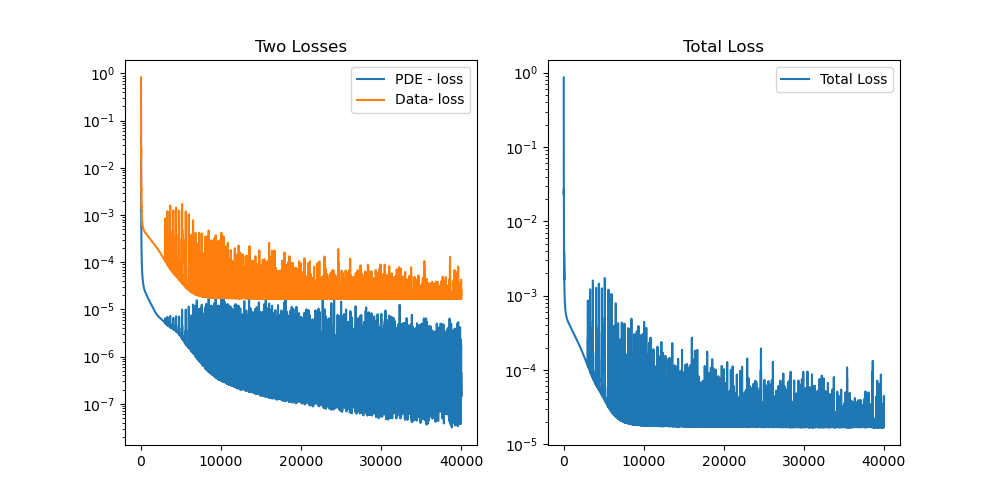

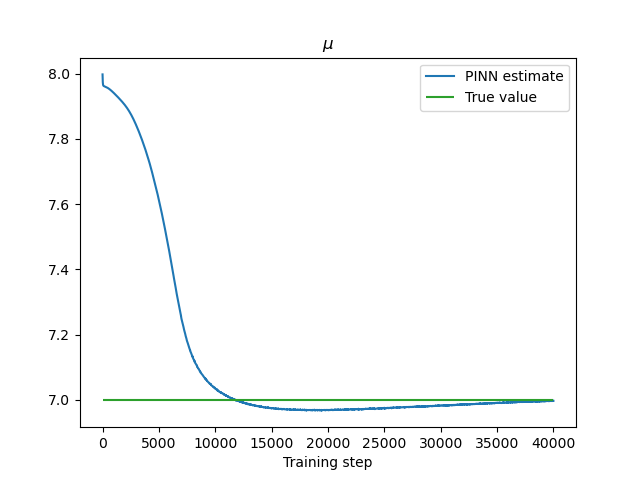

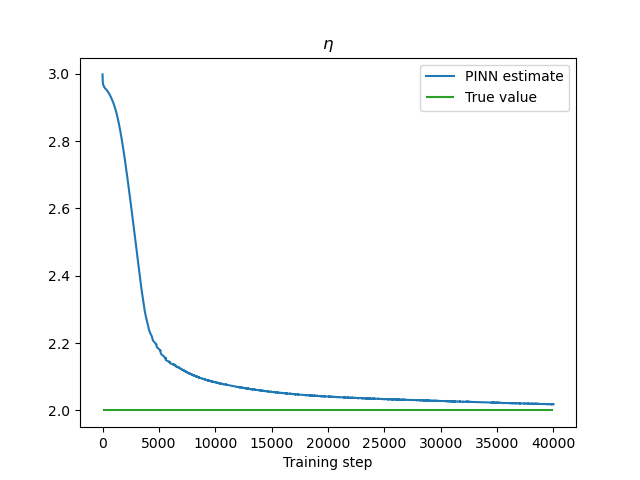

In [468]:
# Plot for mu
fig, ax = plt.subplots()
plt.title("$\mu$")
plt.plot(mu_s, label="PINN estimate")
plt.hlines(MU, 0, len(mu_s), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
# Save the figure for mu
fig.savefig(os.path.join(folder_name, "mu_identification.png"))


# Plot for eta
fig, ax = plt.subplots()
plt.title("$\eta$")
plt.plot(eta_s, label="PINN estimate")
plt.hlines(ETA, 0, len(eta_s), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
# Save the figure for eta
fig.savefig(os.path.join(folder_name, "eta_identification.png"))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) 
# Plotting Total Loss
total_loss = [
    losses[0][i] + losses[1][i] for i in range(min(len(losses[0]), len(losses[1])))
]
ax2.plot(total_loss, label="Total Loss")
ax2.set_yscale("log")
ax2.legend()
ax2.set_title("Total Loss")

ln1 = ax1.plot(losses[0], label="PDE - loss")
ln2 = ax1.plot(losses[1], label="Data- loss")
ax1.set_yscale("log")

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
ax1.set_title("Two Losses")

fig.savefig(os.path.join(folder_name, "Loss.png"))
plt.show()



# Save window results

In [469]:
# # Define your dataloaders in a list
# dataloaders = dataloader_window
# # Loop through each dataloader
# for idx, dataloader in enumerate(dataloaders):
#     # Call the function and pass the respective parameters
#     losses, mu_s, eta_s, pinn = train_model(dataloader)
    
#     # Process the returned lists of losses and parameter values
#     # Create folder for this training iteration
#     sub_folder_name = os.path.join(folder_name, f"training_{idx+1}")
#     try:
#         os.makedirs(sub_folder_name, exist_ok=True)
#         print(f"Subfolder '{sub_folder_name}' created successfully!")
#     except FileExistsError:
#         print(f"Subfolder '{sub_folder_name}' already exists.")
#     except Exception as e:
#         print(f"Error occurred while creating the subfolder: {e}")

#     # Save the mu and eta values to a file
#     mu_file_path = os.path.join(sub_folder_name, 'mu_data.pkl')
#     with open(mu_file_path, 'wb') as f:
#         pickle.dump(mu_s, f)

#     eta_file_path = os.path.join(sub_folder_name, 'eta_data.pkl')
#     with open(eta_file_path, 'wb') as f:
#         pickle.dump(eta_s, f)

#     # Plot for mu
#     fig, ax = plt.subplots()
#     plt.title("$\mu$")
#     plt.plot(mu_s, label="PINN estimate")
#     plt.hlines(MU, 0, len(mu_s), label="True value", color="tab:green")
#     plt.legend()
#     plt.xlabel("Training step")
#     # Save the figure for mu
#     fig.savefig(os.path.join(sub_folder_name, "mu_identification.png"))
#     plt.close()

#     # Plot for eta
#     fig, ax = plt.subplots()
#     plt.title("$\eta$")
#     plt.plot(eta_s, label="PINN estimate")
#     plt.hlines(ETA, 0, len(eta_s), label="True value", color="tab:green")
#     plt.legend()
#     plt.xlabel("Training step")
#     # Save the figure for eta
#     fig.savefig(os.path.join(sub_folder_name, "eta_identification.png"))
#     plt.close()

#     # Plot Loss
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) 
#     total_loss = [losses[0][i] + losses[1][i] for i in range(min(len(losses[0]), len(losses[1])))]
#     ax2.plot(total_loss, label="Total Loss")
#     ax2.set_yscale("log")
#     ax2.legend()
#     ax2.set_title("Total Loss")

#     ln1 = ax1.plot(losses[0], label="PDE - loss")
#     ln2 = ax1.plot(losses[1], label="Data- loss")
#     ax1.set_yscale("log")
#     lns = ln1 + ln2
#     labs = [l.get_label() for l in lns]
#     ax1.legend(lns, labs, loc=0)
#     ax1.set_title("Two Losses")

#     fig.savefig(os.path.join(sub_folder_name, "Loss.png"))
#     plt.close()

#     # plt.show()

In [470]:
torch.save(pinn.state_dict(), os.path.join(folder_name, "model.pth"))

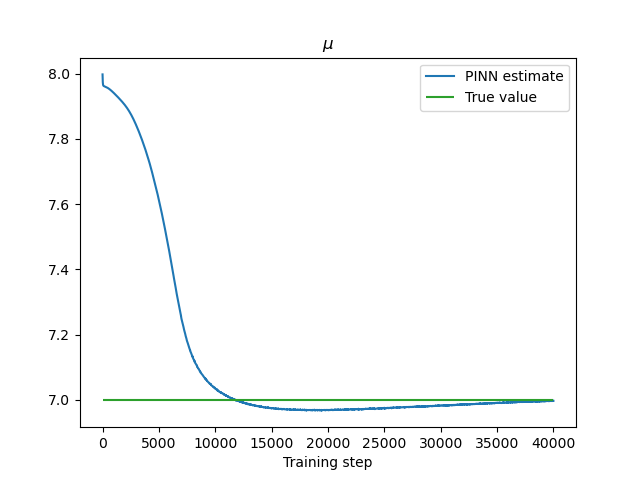

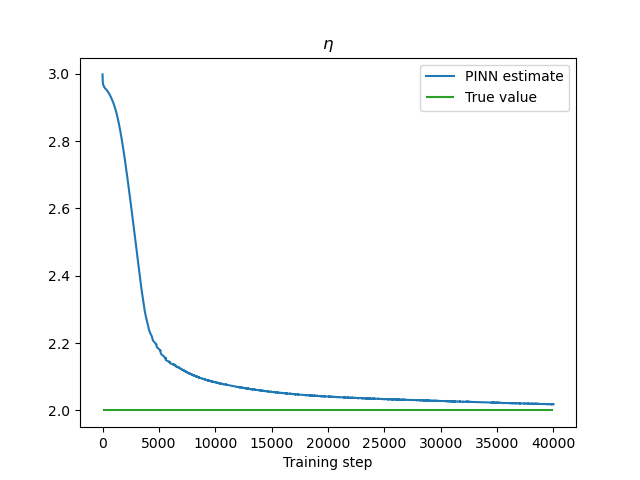

In [471]:
# Plot for mu
fig, ax = plt.subplots()
plt.title("$\mu$")
plt.plot(mu_s, label="PINN estimate")
plt.hlines(MU, 0, len(mu_s), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
# Save the figure for mu
fig.savefig(os.path.join(folder_name, "mu_identification.png"))


# Plot for eta
fig, ax = plt.subplots()
plt.title("$\eta$")
plt.plot(eta_s, label="PINN estimate")
plt.hlines(ETA, 0, len(eta_s), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
# Save the figure for eta
fig.savefig(os.path.join(folder_name, "eta_identification.png"))



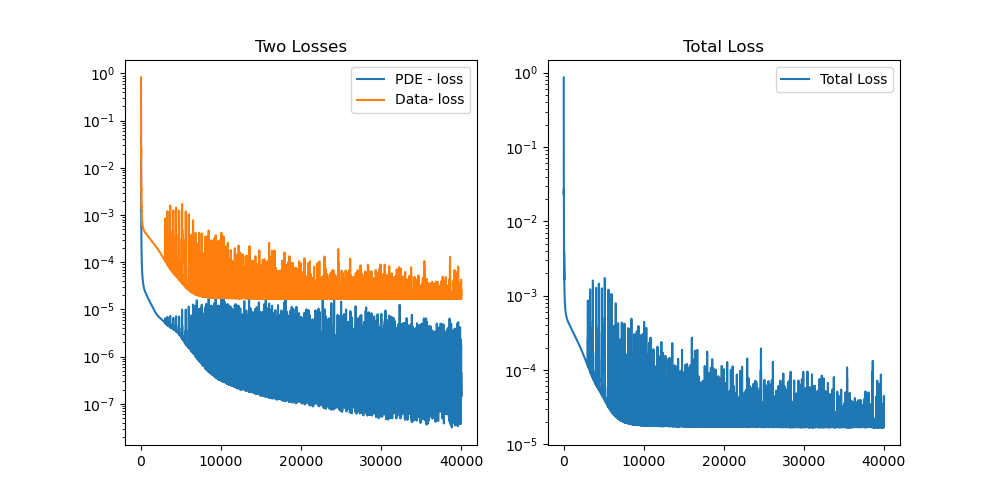

In [472]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) 
# Plotting Total Loss
total_loss = [
    losses[0][i] + losses[1][i] for i in range(min(len(losses[0]), len(losses[1])))
]
ax2.plot(total_loss, label="Total Loss")
ax2.set_yscale("log")
ax2.legend()
ax2.set_title("Total Loss")

ln1 = ax1.plot(losses[0], label="PDE - loss")
ln2 = ax1.plot(losses[1], label="Data- loss")
ax1.set_yscale("log")

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
ax1.set_title("Two Losses")

fig.savefig(os.path.join(folder_name, "Loss.png"))
plt.show()

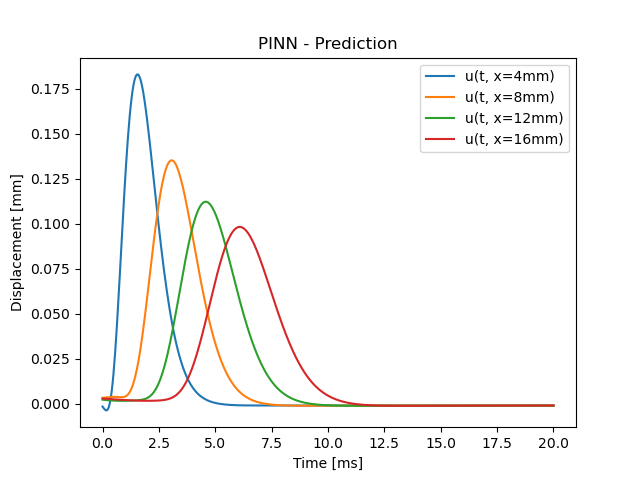

In [473]:
selected_x_values = [4, 8, 12, 16]
num_test_samples = 500

# Set the model to evaluation mode
pinn.eval()

# Create a single figure
fig, ax = plt.subplots()

# Plot u(t, x) for each selected x on the same graph
for selected_x in selected_x_values:
    # Predict u(t, x) distribution for the fixed x
    t_flat = np.linspace(0, 20, num_test_samples)
    x_flat = np.full_like(t_flat, fill_value=selected_x)
    tx = np.stack([t_flat, x_flat], axis=-1)

    # Convert to torch tensors

    x_tensor = torch.from_numpy(tx[:, 1]).float().view(-1, 1).to(device)
    t_tensor = torch.from_numpy(tx[:, 0]).float().view(-1, 1).to(device)

    # Forward pass
    u_pinn = pinn(x_tensor, t_tensor).detach()

    # Move predicted values to CPU for plotting
    u_pinn = u_pinn.cpu().numpy()

    # Plot the result
    ax.plot(t_flat, u_pinn, label=f'u(t, x={selected_x}mm)')

ax.set_title("PINN - Prediction")
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Displacement [mm]")
ax.legend()
plt.show()
fig.savefig(os.path.join(folder_name, "PINN - Prediction.png"))

In [474]:
# Create a string with the variable values
variables_str = f"""A = {A}
SIGMA = {SIGMA}
MU = {MU}
ETA = {ETA}
INITIAL_GUESS_MU = {INITIAL_GUESS_MU}
INITIAL_GUESS_ETA = {INITIAL_GUESS_ETA}
CS = {CS}
RHO = {RHO}
RATIO = {RATIO}
N_NEUROS = {N_NEUROS}
N_LAYERS = {N_LAYERS}
LR = {LR}
x_range = {x_range}
t_range = {t_range}
lambda1 = {lambda1}
lambda2 = {lambda2}
lambda3 = {lambda3}
lambda4 = {lambda4}
SNR = {SNR}
noise_flag = {noise_flag}
epochs = {epochs}
"""

# Write the string to a text file in the same folder
with open(os.path.join(folder_name, "variable_values.txt"), "w") as file:
    file.write(variables_str)

print("Variable values saved to 'variable_values.txt'")

Variable values saved to 'variable_values.txt'
